In [1]:
!pip install pyspark
!pip install wordcloud

In [34]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

%matplotlib inline

ModuleNotFoundError: No module named 'wordcloud'

# 1. Data Extraction

## 1.1 Setting up folder and file name

In [3]:
f_path = '../stacksample/'
#answers = 'Answers.csv'
questions = 'Questions.csv'
tags = 'Tags.csv'

#answers_df = pd.read_csv(f_path+answers, sep=',', encoding='latin-1')

## 1.2 Read data from CSV files

In [4]:
tags_df = pd.read_csv(f_path+tags, sep=',', encoding='latin-1')
tags_df.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [5]:
tags_df.tail()

,Id,Tag
3750989,40143360,javascript
3750990,40143360,vue.js
3750991,40143380,npm
3750992,40143380,mocha
3750993,40143380,babel


In [6]:
questions_df = pd.read_csv(f_path+questions, sep=',', encoding='latin-1')
questions_df.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [7]:
questions_df.tail()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
1264211,40143210,5610777.0,2016-10-19T23:38:01Z,NaN,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...
1264212,40143300,3791161.0,2016-10-19T23:48:09Z,NaN,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...
1264213,40143340,7028647.0,2016-10-19T23:52:50Z,NaN,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...
1264214,40143360,871677.0,2016-10-19T23:55:24Z,NaN,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...
1264215,40143380,6823982.0,2016-10-19T23:57:31Z,NaN,0,npm run mocha test - files being cached,<p>I'm running a mocha test and I noticed my c...


## 1.3 Performing basic checks

In [8]:
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
Id              1264216 non-null int64
OwnerUserId     1249762 non-null float64
CreationDate    1264216 non-null object
ClosedDate      55959 non-null object
Score           1264216 non-null int64
Title           1264216 non-null object
Body            1264216 non-null object
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [9]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
Id     int64
Tag    object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [10]:
tags_df.describe()

,Id
count,3.750994e+06
mean,2.148285e+07
std,1.147246e+07
min,8.000000e+01
25%,1.164430e+07
50%,2.196248e+07
75%,3.164509e+07
max,4.014338e+07


In [11]:
questions_df.describe()

,Id,OwnerUserId,Score
count,1.264216e+06,1.249762e+06,1.264216e+06
mean,2.132745e+07,2.155177e+06,1.781537e+00
std,1.151445e+07,1.801265e+06,1.366389e+01
min,8.000000e+01,1.000000e+00,-7.300000e+01
25%,1.142598e+07,6.589110e+05,0.000000e+00
50%,2.172542e+07,1.611830e+06,0.000000e+00
75%,3.154542e+07,3.353792e+06,1.000000e+00
max,4.014338e+07,7.046594e+06,5.190000e+03


In [36]:
"""
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext()
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)
    
from pyspark.sql.functions import col
from pyspark.sql.functions import sum as spark_sum

def count_null(col_name):
    return spark_sum(col(col_name).isNull().cast('integer')).alias(col_name)

# Build up a list of column expressions, one per column.
exprs = [count_null(col_name) for col_name in tags_df]

# Run the aggregation. The *exprs converts the list of expressions into
# variable function arguments.
# tags_df.agg(*exprs).head()
exprs 


""""

In [12]:
questions_df['Body'][4]

'<p>I have a little game written in C#. It uses a database as back-end. It\'s \na <a href="http://en.wikipedia.org/wiki/Collectible_card_game">trading card game</a>, and I wanted to implement the function of the cards as a script.</p>\n\n<p>What I mean is that I essentially have an interface, <code>ICard</code>, which a card class implements (<code>public class Card056 : ICard</code>) and which contains function that are called by the game.</p>\n\n<p>Now, to make the thing maintainable/moddable, I would like to have the class for each card as source code in the database and essentially compile it on first use. So when I have to add/change a card, I\'ll just add it to the database and tell my application to refresh, without needing any assembly deployment (especially since we would be talking about 1 assembly per card which means hundreds of assemblies).</p>\n\n<p>Is that possible? Register a class from a source file and then instantiate it, etc.</p>\n\n<pre><code>ICard Cards[current] =

# 2. Data Wrangling

## 2.1 Converting the HTML based field in dataframe to an ordinary dataframe field

In [13]:
def body_cleanser(body):
    #body = BeautifulSoup(questions_df['Body'][0], 'html.parser').replace('\n','')
    soup = BeautifulSoup(body, 'html.parser')
    soup = soup.text.replace('\n', '')
    return soup

questions_df['Body_Cleansed'] = questions_df['Body'].apply(body_cleanser)
questions_df.head(10)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body,Body_Cleansed
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,I've written a database generation script in S...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,Are there any really good tutorials explaining...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,Has anyone got experience creating SQL-based A...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,This is something I've pseudo-solved many time...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,I have a little game written in C#. It uses a ...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,I am working on a collection of classes used f...
6,470,71.0,2008-08-02T15:11:47Z,2016-03-26T05:23:29Z,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,I've been writing a few web services for a .ne...
7,580,91.0,2008-08-02T23:30:59Z,NaN,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,I wonder how you guys manage deployment of a d...
8,650,143.0,2008-08-03T11:12:52Z,NaN,79,Automatically update version number,<p>I would like the version property of my app...,I would like the version property of my applic...
9,810,233.0,2008-08-03T20:35:01Z,NaN,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,I'm trying to maintain a Setup Project in Visu...


## 2.2 Checking for NULLs

In [14]:
questions_df.isnull().sum()

Id                     0
OwnerUserId        14454
CreationDate           0
ClosedDate       1208257
Score                  0
Title                  0
Body                   0
Body_Cleansed          0
dtype: int64

## 2.3 Removing unwanted columns

In [17]:
del questions_df['OwnerUserId']

In [18]:
del questions_df['ClosedDate']

In [19]:
#tags_df[tags_df.Tag == np.nan].count(),tags_df[tags_df.Id == np.nan].count()
questions_df.isnull().sum()

Id               0
CreationDate     0
Score            0
Title            0
Body             0
Body_Cleansed    0
dtype: int64

## 2.4 Joining Questions and Tags datasets for easy handling

In [78]:
stackoverflow_df = pd.merge(left=questions_df, right=tags_df, left_on='Id', right_on='Id')
del stackoverflow_df['Body']
del stackoverflow_df['CreationDate']
del stackoverflow_df['Score']
stackoverflow_df.rename(columns={"Body_Cleansed": "Body"}, inplace = True)
stackoverflow_df.head()

,Id,Title,Body,Tag
0,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,flex
1,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,actionscript-3
2,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,air
3,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,svn
4,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,tortoisesvn


## 2.4 Handling NULLs on the merged Stack Overflow dataset

In [80]:
stackoverflow_future_test_df = stackoverflow_df[stackoverflow_df.Tag.isnull()]
stackoverflow_future_test_df.head()

,Id,Title,Body,Tag,Title_word_count,Body_word_count
947,32280,Passing null to a method,I am in the middle of reading the excellent Cl...,NaN,24,1137
4755,140030,Possible causes of Java VM EXCEPTION_ACCESS_VI...,When a Java VM crashes with an EXCEPTION_ACCES...,NaN,54,368
6892,191640,Get null == null in SQL,I wish to search a database table on a nullabl...,NaN,23,373
11107,283190,Asp.net Date Binding Issue with Nulls,I have a nullable date in my database. I am co...,NaN,37,621
11570,291340,Mark parameters as NOT nullable in C#/.NET?,Is there a simple attribute or data contract t...,NaN,43,582


In [81]:
stackoverflow_df = stackoverflow_df.drop(stackoverflow_df[stackoverflow_df.Tag.isnull()].index)
stackoverflow_df.Tag.isnull().sum()

0

## 2.5 Creating Tag count Dataset for tag based analysis

In [45]:
tag_new_df = stackoverflow_df[['Id','Tag']]
tag_count_df = tag_new_df.groupby('Tag').count().reset_index().sort_values(by='Id', ascending=False)
tag_count_df.rename(columns={"Id": "Tag_Count"}, inplace = True)

In [47]:
tag_count_df.head(10)

,Tag,Tag_Count
16121,javascript,124155
16020,java,115212
4301,c#,101186
24211,php,98808
979,android,90659
16611,jquery,78542
25712,python,64601
14180,html,58976
4311,c++,47591
15565,ios,47009


## 2.6 Plotting matplot charts on the fields that will be used in the tag prediction to analyze further discrepancies (if any).

<Figure size 1080x720 with 0 Axes>

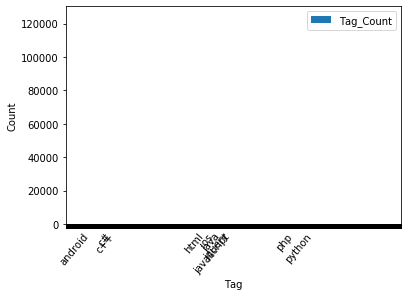

'\ntag_count_df[:10].plot(x=\'Tag\', y=\'Id\',  rot=70, title="Tag based Count")\nplt.xticks(tag_count_df.index,tag_count_df["Tag"].values)\nplt.show() '

In [54]:
tag_sample_df = tag_count_df[:10]


plt.figure(figsize=(15,10))
tag_sample_df.plot.bar(x='Tag', y='Tag_Count')
plt.xticks(rotation=50)
plt.xticks(tag_count_df.index,tag_sample_df["Tag"].values)
plt.xlabel("Tag")
plt.ylabel("Count")
plt.show()

"""
tag_count_df[:10].plot(x='Tag', y='Id',  rot=70, title="Tag based Count")
plt.xticks(tag_count_df.index,tag_count_df["Tag"].values)
plt.show() """
#tag_sample_df.head()

In [68]:
tag_string = ''
def tag_maker(tag):
    tag_string = ' '+tag
    return tag_string

tag_string = tag_count_df.Tag.apply(tag_maker)
len(tag_string)
tag_string

16121     javascript
16020           java
4301              c#
24211            php
979          android
            ...     
31989           tbcd
10167     evil-dicom
10169            evo
31986           tbar
24456         pjsua2
Name: Tag, Length: 37034, dtype: object

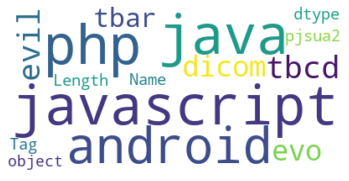

In [76]:
#text = tag_count_df['Tag']
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white").generate(str(tag_string))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
def word_count(str):
     return len(str)

stackoverflow_df['Title_word_count'] = stackoverflow_df.Title.apply(word_count)
stackoverflow_df['Body_word_count'] = stackoverflow_df.Body.apply(word_count)
stackoverflow_df.head()

,Id,Title,Body,Tag,Title_word_count,Body_word_count
0,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,flex,58,1685
1,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,actionscript-3,58,1685
2,80,SQLStatement.execute() - multiple queries in o...,I've written a database generation script in S...,air,58,1685
3,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,svn,53,147
4,90,Good branching and merging tutorials for Torto...,Are there any really good tutorials explaining...,tortoisesvn,53,147
